# Logistic Regression
- Contents:
 - Data prep
 - Plain logr model
 - logr with upsampling (SMOTE) and gridsearch
 - Confusion matricies
 - PnL analysis (test and whole dataset)
 - Loop to search range of  'approval' ratings
 - ROC curve

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 50)

In [62]:
import sys
sys.path.append('../lending_club')
import config
from data_prep import get_lending_club_data, refine_features
from model_analysis import output_confusion_matrix

In [63]:
%%time
approved = pd.read_parquet('../data/approved_20210329.parquet')

Wall time: 4.63 s


In [64]:
approved.dtypes

addr_state                  object
annual_inc                 float64
application_type            object
disbursement_method         object
dti                        float64
                            ...   
verification_status         object
zip_code                    object
days_since_first_credit      int64
fico_score_average         float64
PnL                        float64
Length: 32, dtype: object

### create df_full to get back PnL for model driven portfolio later

In [65]:
df_full = approved.copy(deep=True)

### Removed NA's

In [31]:
approved.drop(['emp_title', 'earliest_cr_line', 'grade', 'zip_code', 'last_pymnt_d','total_pymnt','PnL'], axis = 1, inplace = True)

In [32]:
approved.dropna(axis = 0, inplace = True)

### Dummification

In [33]:
%%time
for d in ['addr_state', 'application_type', 'disbursement_method', 'home_ownership', \
          'initial_list_status', 'purpose','verification_status','sub_grade']:
    temp = pd.get_dummies(approved[d], prefix=d, prefix_sep='__')
    temp = temp.drop(d+'__'+str(approved[d].mode()[0]), axis=1)
    #drop the most common one (mode), making it the base case
    approved = pd.concat([approved.drop(d, axis=1),temp], axis=1)
    #merge back with main df

Wall time: 8.78 s


### Create 'combined' DataFrame (combo of 36mo and 60mo loans)


In [34]:
from model_prep import divide_by_term

three_year = divide_by_term(approved, 36)
five_year = divide_by_term(approved, 60)
combined = pd.concat([three_year,five_year],axis=0)

In [35]:
combined.drop('issue_d', axis = 1, inplace = True)

### Logistic Regression (plain = no gridsearch, no upsampling)

In [36]:
combined.shape

(660903, 113)

In [37]:
target = combined['loan_status']
features = combined.drop('loan_status', axis = 1)

In [39]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold

Xtrain, Xtest, ytrain, ytest = train_test_split(features, target, train_size=.8)
logr = LogisticRegression(max_iter=1e8)

In [40]:
logr.fit(Xtrain, ytrain)

LogisticRegression(max_iter=100000000.0)

In [41]:
output_confusion_matrix(logr, Xtest, ytest)

,Pred: Charged Off,Pred: Fully Paid
True: Charged Off,54,19158
True: Fully Paid,72,112897


In [42]:
print(logr.score(Xtest, ytest))
print(logr.score(Xtrain,ytrain))

0.8545176689539343
0.8555157530800686


### Summary: logr is predicting the null model because of the data imbalance
### Next steps:
- Use SMOTE for upsampling
- GridsearchCV for parameter tuning

### SMOTE to oversample minority class (defaulted loans)

In [43]:
%%time
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(Xtrain, ytrain)

Wall time: 2min 56s


In [44]:
print(y_oversample.value_counts())
print(ytest.value_counts())

1    452440
0    452440
Name: loan_status, dtype: int64
1    112969
0     19212
Name: loan_status, dtype: int64


### Gridsearch

In [45]:
Cs = [0.0001,0.001,0.01,1,10,100,1000,10000]
params = [{'C':Cs, 'penalty':['l1','l2']}]
grid_logr = GridSearchCV(estimator=logr, param_grid=params, cv=3)

In [46]:
%%time
grid_logr.fit(X_oversample, y_oversample)

Wall time: 7min 13s


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=100000000.0),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 1, 10, 100, 1000, 10000],
                          'penalty': ['l1', 'l2']}])

In [47]:
print(grid_logr.best_params_)
print(grid_logr.best_score_)

{'C': 10000, 'penalty': 'l2'}
0.641202147196168


In [48]:
best_model = grid_logr.best_estimator_
best_model.score(Xtest,ytest)

0.6219275084921434

In [49]:
coefs = pd.DataFrame(abs(best_model.coef_).T, index=features.columns)

In [50]:
coefs.sort_values(0, ascending=False).head(10)

,0
int_rate,0.090795
term,0.073077
emp_length,0.029408
dti,0.018844
verification_status__Not Verified,0.013121
purpose__credit_card,0.010889
initial_list_status__f,0.010761
inq_last_6mths,0.009948
verification_status__Verified,0.008826
home_ownership__RENT,0.008229


In [51]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(ytest,best_model.predict(Xtest))

#Label the confusion matrix
pd.DataFrame(cmat, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])

,Pred_0,Pred_1
True_0,11859,7353
True_1,42621,70348


In [52]:
cmat=cmat
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')

loan approval rate: 0.59
precision pred_1: 0.91
recall pred_1: 0.62


In [53]:
from sklearn.metrics import classification_report
print(classification_report(ytest, best_model.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.22      0.62      0.32     19212
           1       0.91      0.62      0.74    112969

    accuracy                           0.62    132181
   macro avg       0.56      0.62      0.53    132181
weighted avg       0.81      0.62      0.68    132181



### PnL analysis for the TEST set

- These steps will 
 -  Create the logr model 'approved' portolio 
 -  Bring back the PnL from the raw data frame and

In [70]:
model_results = pd.Series(best_model.predict(Xtest), index = Xtest.index, name="loan_status_predict")
df2 = pd.concat([Xtest, ytest, model_results], axis=1 )
model_port = df2.loc[df2['loan_status_predict'] == 1]
PnL = df_full['PnL']
model_port = model_port.merge(PnL, how='inner',left_index=True,right_index=True)

In [71]:
print(f'Total investment for Model Portfolio: {model_port.loan_amnt.sum():.0f}')
print(f'Total PnL for Model Portfolio: {model_port.PnL.sum():.0f}')
print(f'Return for Model Portfolio: {(model_port.PnL.sum()/model_port.loan_amnt.sum())*100:.2f}%')

Total investment for Model Portfolio: 1020993950
Total PnL for Model Portfolio: 85280363
Return for Model Portfolio: 8.35%


### PnL analysis for the WHOLE set

In [91]:
best_model.score(features,target)
cmat = confusion_matrix(target,best_model.predict(features))

#Label the confusion matrix
pd.DataFrame(cmat, columns = [f'Pred_{label}' for label in best_model.classes_],
             index = [f'True_{label}' for label in best_model.classes_])

,Pred_0,Pred_1
True_0,59207,36287
True_1,213450,351959


In [92]:
from sklearn.metrics import classification_report
print(classification_report(target, best_model.predict(features)))

              precision    recall  f1-score   support

           0       0.22      0.62      0.32     95494
           1       0.91      0.62      0.74    565409

    accuracy                           0.62    660903
   macro avg       0.56      0.62      0.53    660903
weighted avg       0.81      0.62      0.68    660903



In [93]:
cmat=cmat
print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.4f}')
print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.4f}')
print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.4f}')

loan approval rate: 0.5874
precision pred_1: 0.9065
recall pred_1: 0.6225


In [79]:
model_results = pd.Series(best_model.predict(features), index = features.index, name="loan_status_predict")
df2 = pd.concat([features, target, model_results], axis=1 )
model_port = df2.loc[df2['loan_status_predict'] == 1]
PnL = df_full['PnL']
model_port = model_port.merge(PnL, how='inner',left_index=True,right_index=True)

In [80]:
print(f'Total investment for Model Portfolio: {model_port.loan_amnt.sum():.0f}')
print(f'Total PnL for Model Portfolio: {model_port.PnL.sum():.0f}')
print(f'Return for Model Portfolio: {(model_port.PnL.sum()/model_port.loan_amnt.sum())*100:.2f}%')

Total investment for Model Portfolio: 5086028975
Total PnL for Model Portfolio: 427819021
Return for Model Portfolio: 8.41%


### Loop to check performance of different 'approval' thresholds

In [82]:
thresholds = np.linspace(0.5,1,19)

for i in thresholds:
    probs_positive_class = best_model.predict_proba(features)[:, 1]
    prediction = probs_positive_class > i
    cmat = confusion_matrix(target, prediction, labels=[0, 1])
    print(f'threshold:{i:.2f}')
    print(f'loan approval rate: {sum(cmat[:,1])/sum(sum(cmat)):.2f}')
    print(f'precision pred_1: {cmat[1][1]/sum(cmat[:,1]):.2f}')
    print(f'recall pred_1: {cmat[1][1]/sum(cmat[1,:]):.2f}')
    print("-"*50)

threshold:0.50
loan approval rate: 0.59
precision pred_1: 0.91
recall pred_1: 0.62
--------------------------------------------------
threshold:0.53
loan approval rate: 0.52
precision pred_1: 0.91
recall pred_1: 0.56
--------------------------------------------------
threshold:0.56
loan approval rate: 0.46
precision pred_1: 0.92
recall pred_1: 0.50
--------------------------------------------------
threshold:0.58
loan approval rate: 0.40
precision pred_1: 0.93
recall pred_1: 0.43
--------------------------------------------------
threshold:0.61
loan approval rate: 0.34
precision pred_1: 0.93
recall pred_1: 0.38
--------------------------------------------------
threshold:0.64
loan approval rate: 0.29
precision pred_1: 0.94
recall pred_1: 0.32
--------------------------------------------------
threshold:0.67
loan approval rate: 0.24
precision pred_1: 0.94
recall pred_1: 0.27
--------------------------------------------------
threshold:0.69
loan approval rate: 0.19
precision pred_1: 0.95

## ROC Curve

In [84]:
from sklearn.metrics import roc_curve

In [85]:
# predict probabilities
yhat = logr.predict_proba(features)

In [86]:
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

In [87]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(target, yhat)

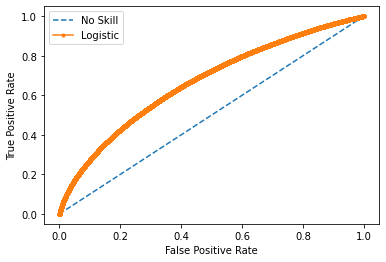

In [88]:
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()